In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.9 MB/s eta 0:00:00


In [3]:
import os
import json
import re
import shutil
import zipfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import keras
import urllib3
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, LayerNormalization, Dense, Masking, Attention, Bidirectional, Concatenate
from tensorflow.keras.models import Model, Sequential

## Data 수집 및 정제
파일 형태가 json이므로 parsing 필요

In [4]:
folder_path = "/content/drive/MyDrive/Data/Data/딥러닝 및 응용_제주도 방언/"

In [5]:
def parse_dialect_data(json_data):
    parsed_data = json.loads(json_data)
    dialect_entries = []

    for utterance in parsed_data.get("utterance", []):
        eojeol_list = utterance.get("eojeolList", [])
        for eojeol in eojeol_list:
            if eojeol.get("isDialect", False):
                standard_form = utterance.get("standard_form", "")
                dialect_form = utterance.get("dialect_form", "")
                dialect_entries.append({"standard_form": standard_form, "dialect_form": dialect_form})

    return dialect_entries

def parse_json_files_in_folder(folder_path):
    parsed_entries = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                json_data = file.read()
                entries = parse_dialect_data(json_data)
                parsed_entries.extend(entries)

    return parsed_entries

parsed_entries = parse_json_files_in_folder(folder_path)

In [6]:
# 중복 제거하기
unique_entries = [dict(t) for t in {tuple(d.items()) for d in parsed_entries}]

In [7]:
# 중복을 제거했음에도 불필요하게 너무 많은 데이터의 양..
len(unique_entries)

530878

In [8]:
# 특수문자가 없는 요소만 가져와서 list 만들기
def parse_and_clean_entries(entries):
    cleaned_entries = []

    for entry in entries:
        standard_form = entry['standard_form']
        dialect_form = entry['dialect_form']

        # 괄호와 특수문자를 포함하지 않는 경우에만 추가
        if not re.search(r'[\(\)\[\]\{\}\<\>\!\@\#\$\%\^\&\*\-\+\=\_\\\/\?\,\'\"\.\:\;\|\`\~\@\#\*\&\^\-]', standard_form+dialect_form):
            cleaned_entries.append({"standard_form": standard_form, "dialect_form": dialect_form})

    return cleaned_entries

In [9]:
# 데이터 자체가 많기 때문에, 특수 문자가 있는 문장은 다 제거한다.
clean_text = parse_and_clean_entries(unique_entries)

# 표준어와 방언은 각각의 리스트로 분리한다.
standard_forms = [entry["standard_form"] for entry in clean_text]
dialect_forms = [entry["dialect_form"] for entry in clean_text]

In [10]:
# 데이터의 길이 확인
print("표준어 데이터의 길이:", len(standard_forms))
print("방언 데이터의 길이:", len(dialect_forms))

표준어 데이터의 길이: 245003
방언 데이터의 길이: 245003


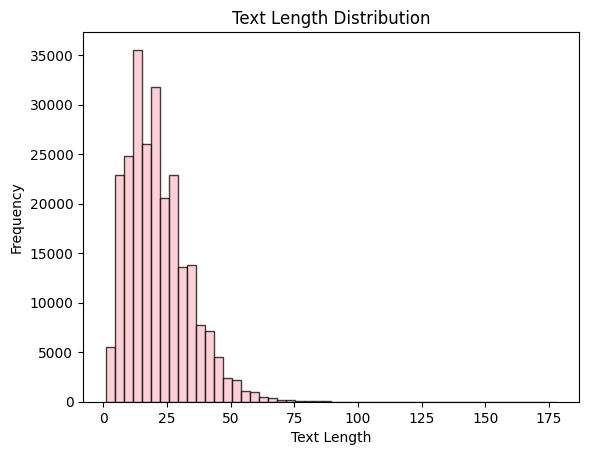

In [11]:
# EDA - 표준어 데이터의 문장 길이 분포
standard_text_lengths = [len(text) for text in standard_forms]
dialect_text_lengths = [len(text) for text in dialect_forms]

plt.hist(standard_text_lengths, bins=50, alpha=0.75, color='pink', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

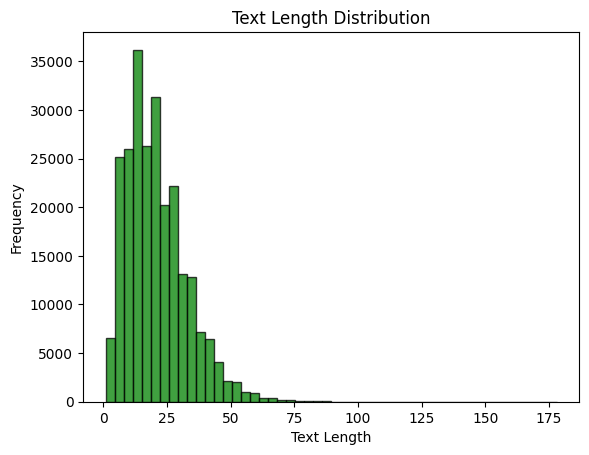

In [12]:
# EDA - 방언 데이터의 문장 길이 분포
plt.hist(dialect_text_lengths, bins=50, alpha=0.75, color='g', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
# 토큰화 및 정수 인코딩
from konlpy.tag import Okt

tokenizer = Okt()

# 토큰화 함수 정의 -> okt를 통한 한국어 토크나이징
def tokenize(texts):
    return [tokenizer.morphs(text) for text in texts]

# 표준어와 방언 데이터를 X와 y로 나누기, 총 20000개 사용
X = standard_forms[:20000]
y = dialect_forms[:20000]

# 표준어와 방언 데이터를 토큰화
X_tokenized = tokenize(X)
y_tokenized = tokenize(y)

# SOS와 EOS 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'

# 디코더의 예측, 학습을 위한 데이터 각각 만들기
y_tokenized_input = [[sos_token] + seq for seq in y_tokenized] # 학습
y_tokenized_target = [seq + [eos_token] for seq in y_tokenized] # 예측

# 토큰을 정수로 변환하는 Tokenizer 생성
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(X_tokenized)
x_encoded = x_tokenizer.texts_to_sequences(X_tokenized)

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_tokenized_input + y_tokenized_target)
y_encoded_input = y_tokenizer.texts_to_sequences(y_tokenized_input)
y_encoded_target = y_tokenizer.texts_to_sequences(y_tokenized_target)

# 패딩 추가, pre가 성능이 더 좋다는 말이 있지만 일단 post
encoder_input = pad_sequences(x_encoded, padding='post')
decoder_input = pad_sequences(y_encoded_input, padding='post')
decoder_target = pad_sequences(y_encoded_target, padding='post')

# 학습, 검증, 테스트 데이터로 나누기
n_of_val = int(20000*0.1)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 각 데이터셋의 크기 확인
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (18000, 45)
훈련 target 데이터의 크기 : (18000, 48)
훈련 target 레이블의 크기 : (18000, 48)
테스트 source 데이터의 크기 : (2000, 45)
테스트 target 데이터의 크기 : (2000, 48)
테스트 target 레이블의 크기 : (2000, 48)


In [85]:
# 체크
print(y_tokenized_input[1])
print(y_tokenized_target[1])

print(decoder_input_train[1])
print(decoder_target_train[1])

['<sos>', '우리', '아들', '꺼', '저기', '뭐', '냐', '도수', '치료', '받은', '거', '이', '신', '디']
['우리', '아들', '꺼', '저기', '뭐', '냐', '도수', '치료', '받은', '거', '이', '신', '디', '<eos>']
[   1   18  192  427  115   24  165 5590 1463 1040    7    3  133   15
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[  18  192  427  115   24  165 5590 1463 1040    7    3  133   15    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [14]:
# 단어집합 크기, 더 줄여볼 필요가 있을까..
src_vocab_size = len(x_tokenizer.word_index) + 1
tar_vocab_size = len(y_tokenizer.word_index) + 1

print("src_vocab_size: ", src_vocab_size)
print("tar_vocab_size: ", tar_vocab_size)

src_vocab_size:  20197
tar_vocab_size:  22342


###정확도 그래프 그리는 코드

In [53]:
def plot_history(history):
    # 정확도 그래프
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlim(0, 20)
    plt.ylim(0, 1)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### 다른 데이터 사용해보기(영어 - 프랑스어)

In [36]:
# 한국어이기에 겹치는 데이터가 너무 많아서 동작이 제대로 안 될수도 있다고 판단
# 다른 언어 데이터를 사용해보자 - 수업 실습에서 사용한 데이터 사용

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def download_zip(url, output_path):
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"ZIP file downloaded to {output_path}")
    else:
        print(f"Failed to download. HTTP Response Code: {response.status_code}")

url = "http://www.manythings.org/anki/fra-eng.zip"
output_path = "fra-eng.zip"
download_zip(url, output_path)

path = os.getcwd()
zipfilename = os.path.join(path, output_path)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)


# 동일하게 20000개 사용
num_samples = 20000
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

ZIP file downloaded to fra-eng.zip


In [37]:
def preprocess_sentence(sent):
  # 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

In [38]:
# 토큰화 및 패딩 진행
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 3265, 프랑스어 단어 집합의 크기 : 5913


In [39]:
# 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만듬
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(20000*0.1)
encoder_input_train2 = encoder_input[:-n_of_val]
decoder_input_train2 = decoder_input[:-n_of_val]
decoder_target_train2 = decoder_target[:-n_of_val]

encoder_input_test2 = encoder_input[-n_of_val:]
decoder_input_test2 = decoder_input[-n_of_val:]
decoder_target_test2 = decoder_target[-n_of_val:]

## Seq2seq

In [16]:
embedding_dim = 64 # 임베딩 차원
hidden_units = 64 # 은닉 노드의 수

In [98]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, activation='relu', dropout=0.2, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb) # 패딩 0은 연산에서 제외

# 상태값 리턴을 위해 return_state는 True,
# 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units,
                    activation='relu',
                    dropout=0.2,
                    return_sequences=True,
                    return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

hist = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 96s 590ms/step - loss: 126102.5000 - acc: 0.7535 - val_loss: 153.7063 - val_acc: 0.7645
Epoch 2/20
141/141 [==============================] - 55s 389ms/step - loss: 89.8474 - acc: 0.7693 - val_loss: 53.8344 - val_acc: 0.7625
Epoch 3/20
141/141 [==============================] - 51s 360ms/step - loss: 17580.7363 - acc: 0.3248 - val_loss: 7.6839 - val_acc: 0.3332
Epoch 4/20
141/141 [==============================] - 49s 347ms/step - loss: 4.4875 - acc: 0.6689 - val_loss: 3.0375 - val_acc: 0.7661
Epoch 5/20
141/141 [==============================] - 46s 323ms/step - loss: 2.8111 - acc: 0.7729 - val_loss: 2.8541 - val_acc: 0.7666
Epoch 6/20
141/141 [==============================] - 45s 319ms/step - loss: 2.6320 - acc: 0.7730 - val_loss: 2.5908 - val_acc: 0.7667
Epoch 7/20
141/141 [==============================] - 47s 332ms/step - loss: 2.2469 - acc: 0.7732 - val_loss: 2.6375 - val_acc: 0.7670
Epoch 8/20
141/141 [======================

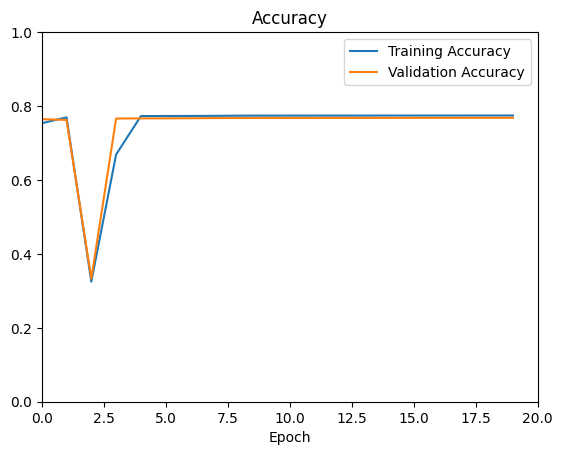

In [54]:
# 손실, 훈련 정확도와 검증 정확도 그래프
plot_history(hist)

In [21]:
# 모델의 정확도가 가파르게 상승하고 어느 순간 멈춰있다. 입력 및 테스트 데이터 반전해보기
# Sutskever et al. "Sequence to sequence learning with neural networks."(2014).

re_encoder_input_train = encoder_input_train[:, ::-1]
re_decoder_input_train = decoder_input_train[:, ::-1]
re_decoder_target_train = decoder_target_train[:, ::-1]

re_encoder_input_test = encoder_input_test[:, ::-1]
re_decoder_input_test = decoder_input_test[:, ::-1]
re_decoder_target_test = decoder_target_test[:, ::-1]

In [24]:
# 체크
print(decoder_input_train[1])
print(re_decoder_input_train[1])

[   1   18  192  427  115   24  165 5590 1463 1040    7    3  133   15
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   15  133    3    7 1040 1463 5590  165   24  115  427  192
   18    1]


In [25]:
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

hist2 = model2.fit(x=[re_encoder_input_train, re_decoder_input_train], y=re_decoder_target_train, \
          validation_data=([re_encoder_input_test, re_decoder_input_test], re_decoder_target_test), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 72s 429ms/step - loss: 36103.2578 - acc: 0.6325 - val_loss: 3.5667 - val_acc: 0.6532
Epoch 2/20
141/141 [==============================] - 49s 348ms/step - loss: 3.2621 - acc: 0.6775 - val_loss: 3.2500 - val_acc: 0.6868
Epoch 3/20
141/141 [==============================] - 57s 405ms/step - loss: 2.9669 - acc: 0.7091 - val_loss: 3.0570 - val_acc: 0.7147
Epoch 4/20
141/141 [==============================] - 46s 326ms/step - loss: 2.7535 - acc: 0.7316 - val_loss: 2.9117 - val_acc: 0.7322
Epoch 5/20
141/141 [==============================] - 46s 324ms/step - loss: 2.5837 - acc: 0.7510 - val_loss: 2.7940 - val_acc: 0.7493
Epoch 6/20
141/141 [==============================] - 48s 338ms/step - loss: 2.4393 - acc: 0.7651 - val_loss: 2.6113 - val_acc: 0.7647
Epoch 7/20
141/141 [==============================] - 45s 322ms/step - loss: 106.7765 - acc: 0.7759 - val_loss: 2.3834 - val_acc: 0.7702
Epoch 8/20
141/141 [=============================

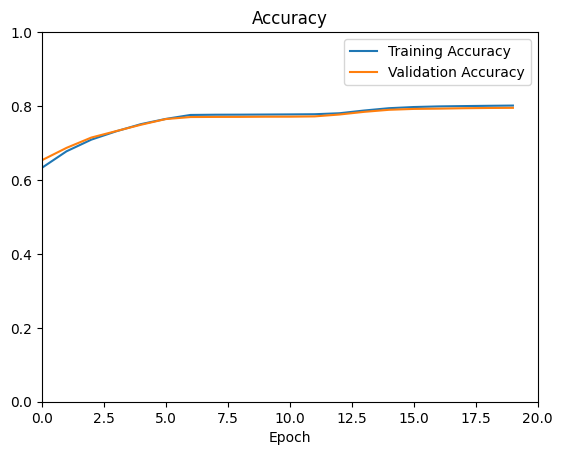

In [55]:
# 손실, 훈련 정확도와 검증 정확도 그래프
plot_history(hist2)

In [102]:
# 동일한 모델에 데이터를 바꿔서 실행해보자!
model3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

hist3 = model3.fit(x=[encoder_input_train2, decoder_input_train2], y=decoder_target_train2, \
          validation_data=([encoder_input_test2, decoder_input_test2], decoder_target_test2), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 33s 191ms/step - loss: 11.2486 - acc: 0.6039 - val_loss: 2.8789 - val_acc: 0.6195
Epoch 2/20
141/141 [==============================] - 15s 108ms/step - loss: 2.6660 - acc: 0.6310 - val_loss: 2.4744 - val_acc: 0.6434
Epoch 3/20
141/141 [==============================] - 16s 111ms/step - loss: 2.3809 - acc: 0.6459 - val_loss: 2.2751 - val_acc: 0.6376
Epoch 4/20
141/141 [==============================] - 16s 112ms/step - loss: 2.1317 - acc: 0.6604 - val_loss: 2.0675 - val_acc: 0.6687
Epoch 5/20
141/141 [==============================] - 14s 100ms/step - loss: 1.9504 - acc: 0.6759 - val_loss: 1.9268 - val_acc: 0.6814
Epoch 6/20
141/141 [==============================] - 14s 100ms/step - loss: 1.8060 - acc: 0.6951 - val_loss: 1.8024 - val_acc: 0.7020
Epoch 7/20
141/141 [==============================] - 15s 109ms/step - loss: 1.6997 - acc: 0.7165 - val_loss: 1.7311 - val_acc: 0.7205
Epoch 8/20
141/141 [==============================] - 

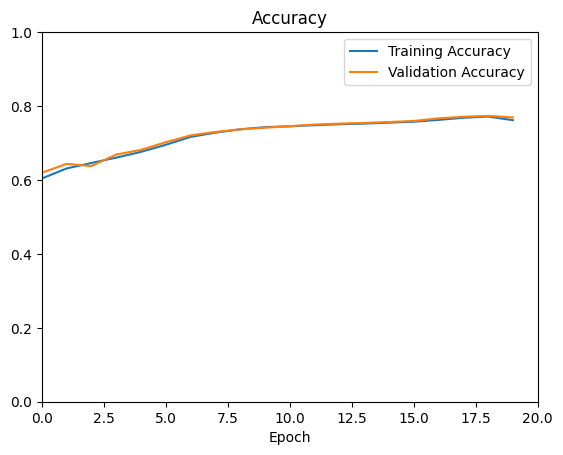

In [103]:
# 손실, 훈련 정확도와 검증 정확도 그래프
plot_history(hist3)

In [44]:
# 동일하게 입력 데이터 반전도 수행해보자
re_encoder_input_train2 = encoder_input_train2[:, ::-1]
re_decoder_input_train2 = decoder_input_train2[:, ::-1]
re_decoder_target_train2 = decoder_target_train2[:, ::-1]

re_encoder_input_test2 = encoder_input_test2[:, ::-1]
re_decoder_input_test2 = decoder_input_test2[:, ::-1]
re_decoder_target_test2 = decoder_target_test2[:, ::-1]

In [34]:
model4 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

hist4 = model4.fit(x=[re_encoder_input_train2, re_decoder_input_train2], y=re_decoder_target_train2, \
          validation_data=([re_encoder_input_test2, re_decoder_input_test2], re_decoder_target_test2), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 30s 165ms/step - loss: 1.6638 - acc: 0.7571 - val_loss: 1.0638 - val_acc: 0.8280
Epoch 2/20
141/141 [==============================] - 16s 111ms/step - loss: 0.7986 - acc: 0.8518 - val_loss: 0.8149 - val_acc: 0.8747
Epoch 3/20
141/141 [==============================] - 15s 107ms/step - loss: 0.5779 - acc: 0.8867 - val_loss: 0.6949 - val_acc: 0.8995
Epoch 4/20
141/141 [==============================] - 14s 101ms/step - loss: 0.4434 - acc: 0.9102 - val_loss: 0.6149 - val_acc: 0.9167
Epoch 5/20
141/141 [==============================] - 14s 101ms/step - loss: 0.3437 - acc: 0.9272 - val_loss: 0.5564 - val_acc: 0.9300
Epoch 6/20
141/141 [==============================] - 14s 101ms/step - loss: 0.2649 - acc: 0.9419 - val_loss: 0.5173 - val_acc: 0.9409
Epoch 7/20
141/141 [==============================] - 14s 100ms/step - loss: 0.2088 - acc: 0.9529 - val_loss: 0.4787 - val_acc: 0.9479
Epoch 8/20
141/141 [==============================] - 1

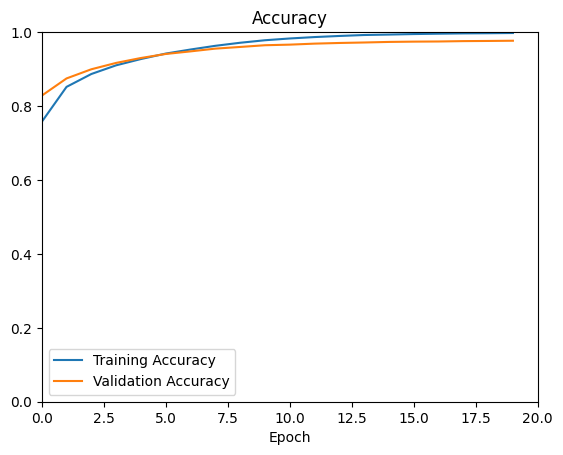

In [57]:
# 손실, 훈련 정확도와 검증 정확도 그래프
plot_history(hist4)

## Seq2seq + Attention

In [40]:
# 인코더
encoder_inputs = Input(shape=(None, ))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_units,
                    activation='relu',
                    dropout=0.2,
                    return_sequences=True,
                    return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

# 디코더
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(tar_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)

decoder_lstm = LSTM(hidden_units,
                    activation='relu',
                    dropout=0.2,
                    return_sequences=True,
                    return_state=True)

Query, h, c = decoder_lstm(dec_masking, initial_state=encoder_states)

# Attention 적용
attention_layer = Attention()

key_value = tf.concat([encoder_states[0][:, tf.newaxis, :], Query[:, :-1, :]], axis=1)

attention_output = attention_layer([key_value, encoder_outputs])
attention_output = tf.concat([Query, attention_output], axis=-1)

# 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(attention_output)

# loss가 자꾸 발산해서 learning rate을 조금 낮춤 0.001 -> 0.00001
optimizer = keras.optimizers.Adam(learning_rate=0.00001)

In [18]:
# 모델의 입력과 출력을 정의.
model_with_attention = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_with_attention.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
hist5 = model_with_attention.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 90s 515ms/step - loss: 10.0105 - acc: 0.0321 - val_loss: 10.0072 - val_acc: 0.6163
Epoch 2/20
141/141 [==============================] - 52s 369ms/step - loss: 10.0027 - acc: 0.7694 - val_loss: 9.9980 - val_acc: 0.7857
Epoch 3/20
141/141 [==============================] - 52s 369ms/step - loss: 9.9896 - acc: 0.7910 - val_loss: 9.9799 - val_acc: 0.7857
Epoch 4/20
141/141 [==============================] - 46s 326ms/step - loss: 9.9604 - acc: 0.7910 - val_loss: 9.9327 - val_acc: 0.7857
Epoch 5/20
141/141 [==============================] - 47s 333ms/step - loss: 7.3312 - acc: 0.7910 - val_loss: 1.8972 - val_acc: 0.7857
Epoch 6/20
141/141 [==============================] - 46s 323ms/step - loss: 2.0359 - acc: 0.7910 - val_loss: 2.1192 - val_acc: 0.7859
Epoch 7/20
141/141 [==============================] - 46s 330ms/step - loss: 1.8089 - acc: 0.7911 - val_loss: 1.8171 - val_acc: 0.7859
Epoch 8/20
141/141 [==============================] 

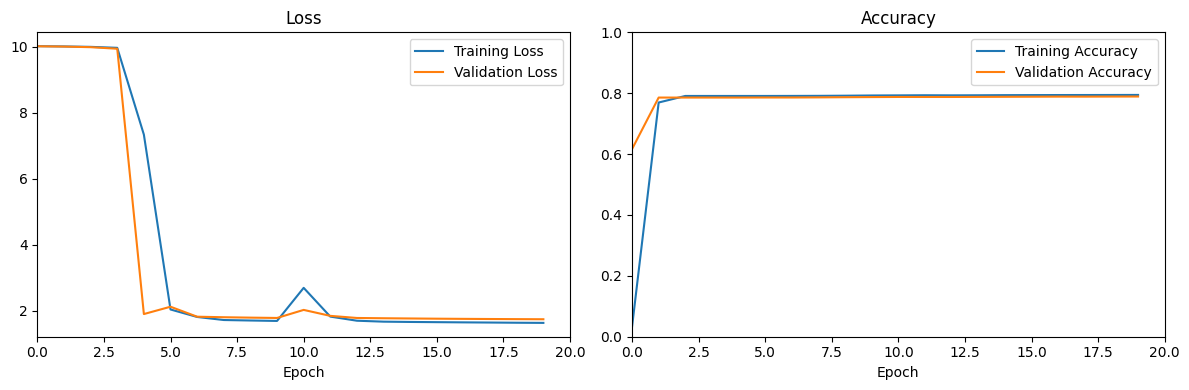

In [19]:
# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist5.history['loss'], label='Training Loss')
plt.plot(hist5.history['val_loss'], label='Validation Loss')
plt.xlim(0, 20)
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(hist5.history['acc'], label='Training Accuracy')
plt.plot(hist5.history['val_acc'], label='Validation Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# 앞뒤를 뒤집은 데이터
model_with_attention2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_with_attention2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
hist8 = model_with_attention2.fit(x=[re_encoder_input_train, re_decoder_input_train], y=re_decoder_target_train, \
          validation_data=([re_encoder_input_test, re_decoder_input_test], re_decoder_target_test), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 61s 381ms/step - loss: 100257.9609 - acc: 0.2658 - val_loss: 42.6301 - val_acc: 0.1805
Epoch 2/20
141/141 [==============================] - 57s 408ms/step - loss: 46.5450 - acc: 0.1998 - val_loss: 42.6844 - val_acc: 0.2031
Epoch 3/20
141/141 [==============================] - 47s 333ms/step - loss: 45.1115 - acc: 0.2359 - val_loss: 41.9396 - val_acc: 0.2701
Epoch 4/20
141/141 [==============================] - 45s 320ms/step - loss: 38.3262 - acc: 0.3682 - val_loss: 15.8136 - val_acc: 0.3505
Epoch 5/20
141/141 [==============================] - 45s 322ms/step - loss: 16.3638 - acc: 0.3964 - val_loss: 15.8285 - val_acc: 0.4224
Epoch 6/20
141/141 [==============================] - 45s 321ms/step - loss: 16.3691 - acc: 0.4746 - val_loss: 15.8798 - val_acc: 0.5066
Epoch 7/20
141/141 [==============================] - 46s 329ms/step - loss: 16.3823 - acc: 0.5544 - val_loss: 15.9251 - val_acc: 0.5812
Epoch 8/20
141/141 [=================

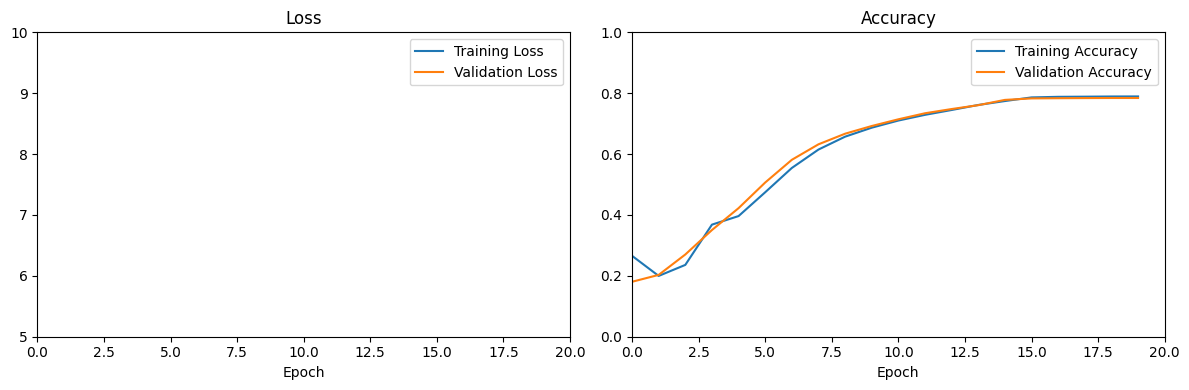

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist8.history['loss'], label='Training Loss')
plt.plot(hist8.history['val_loss'], label='Validation Loss')
plt.xlim(0, 20)
plt.ylim(5, 10)
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(hist8.history['acc'], label='Training Accuracy')
plt.plot(hist8.history['val_acc'], label='Validation Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# 영어 - 프랑스어 데이터
model_with_attention3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_with_attention3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
hist9 = model_with_attention3.fit(x=[encoder_input_train2, decoder_input_train2], y=decoder_target_train2, \
          validation_data=([encoder_input_test2, decoder_input_test2], decoder_target_test2), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 28s 157ms/step - loss: 8.6800 - acc: 0.3158 - val_loss: 8.6773 - val_acc: 0.6160
Epoch 2/20
141/141 [==============================] - 11s 81ms/step - loss: 8.6732 - acc: 0.6170 - val_loss: 8.6695 - val_acc: 0.6160
Epoch 3/20
141/141 [==============================] - 12s 85ms/step - loss: 8.6631 - acc: 0.6169 - val_loss: 8.6568 - val_acc: 0.6160
Epoch 4/20
141/141 [==============================] - 11s 77ms/step - loss: 8.6453 - acc: 0.6169 - val_loss: 8.6325 - val_acc: 0.6160
Epoch 5/20
141/141 [==============================] - 9s 65ms/step - loss: 8.6077 - acc: 0.6169 - val_loss: 8.5753 - val_acc: 0.6160
Epoch 6/20
141/141 [==============================] - 11s 77ms/step - loss: 8.4791 - acc: 0.6169 - val_loss: 8.2641 - val_acc: 0.6160
Epoch 7/20
141/141 [==============================] - 11s 76ms/step - loss: 6.2521 - acc: 0.6169 - val_loss: 4.5930 - val_acc: 0.6160
Epoch 8/20
141/141 [==============================] - 10s 74ms

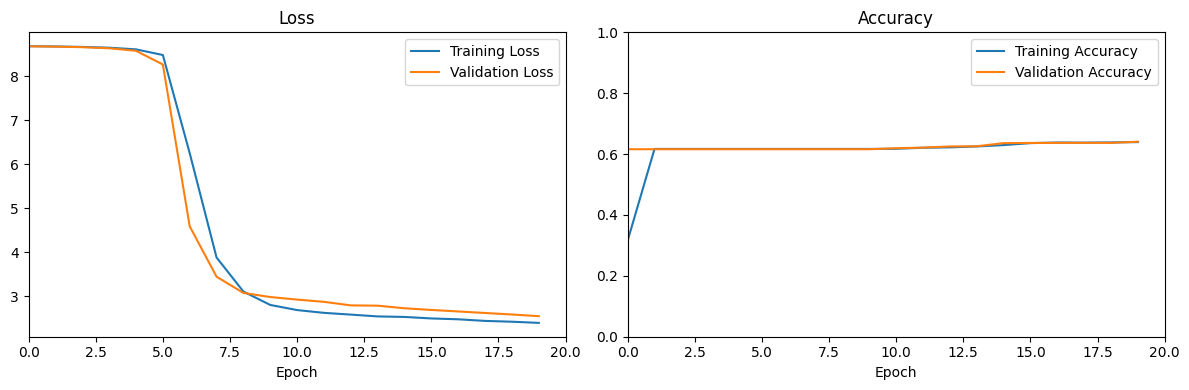

In [42]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist9.history['loss'], label='Training Loss')
plt.plot(hist9.history['val_loss'], label='Validation Loss')
plt.xlim(0, 20)
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(hist9.history['acc'], label='Training Accuracy')
plt.plot(hist9.history['val_acc'], label='Validation Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# 영어 - 프랑스어 뒤집은 데이터
model_with_attention4 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_with_attention4.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
hist10 = model_with_attention4.fit(x=[re_encoder_input_train2, re_decoder_input_train2], y=re_decoder_target_train2, \
          validation_data=([re_encoder_input_test2, re_decoder_input_test2], re_decoder_target_test2), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 14s 78ms/step - loss: 1860.0608 - acc: 0.1108 - val_loss: 467.7711 - val_acc: 0.0847
Epoch 2/20
141/141 [==============================] - 10s 74ms/step - loss: 335.9044 - acc: 0.0968 - val_loss: 238.7994 - val_acc: 0.1328
Epoch 3/20
141/141 [==============================] - 9s 65ms/step - loss: 192.8117 - acc: 0.1279 - val_loss: 152.1508 - val_acc: 0.1339
Epoch 4/20
141/141 [==============================] - 10s 70ms/step - loss: 127.4765 - acc: 0.1394 - val_loss: 104.3889 - val_acc: 0.1431
Epoch 5/20
141/141 [==============================] - 10s 74ms/step - loss: 88.1310 - acc: 0.1350 - val_loss: 74.0423 - val_acc: 0.1159
Epoch 6/20
141/141 [==============================] - 9s 64ms/step - loss: 65.9454 - acc: 0.1046 - val_loss: 57.5056 - val_acc: 0.1001
Epoch 7/20
141/141 [==============================] - 10s 74ms/step - loss: 49.0444 - acc: 0.2239 - val_loss: 44.2955 - val_acc: 0.4218
Epoch 8/20
141/141 [=====================

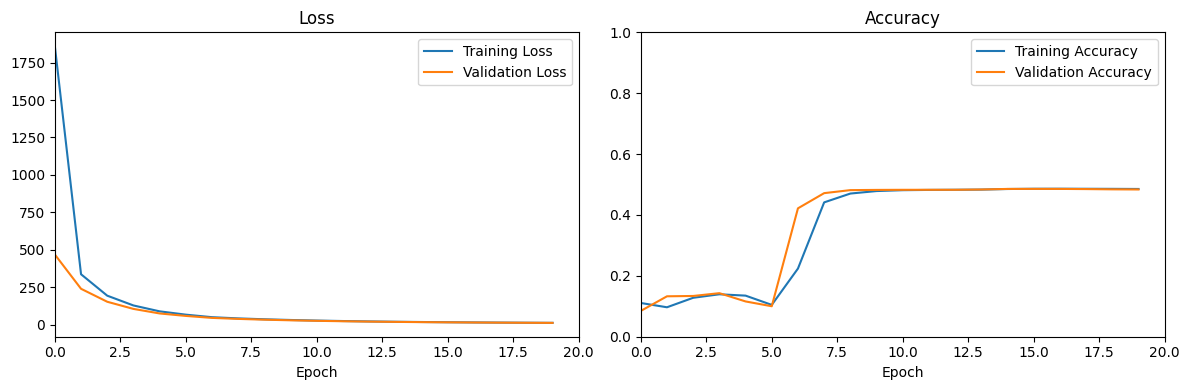

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist10.history['loss'], label='Training Loss')
plt.plot(hist10.history['val_loss'], label='Validation Loss')
plt.xlim(0, 20)
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(hist10.history['acc'], label='Training Accuracy')
plt.plot(hist10.history['val_acc'], label='Validation Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [133]:
# 성능이 오를거 같아서 더 학습시켜 보기 21~40
hist11 = model_with_attention4.fit(x=[re_encoder_input_train2, re_decoder_input_train2], y=re_decoder_target_train2, \
          validation_data=([re_encoder_input_test2, re_decoder_input_test2], re_decoder_target_test2), batch_size=128, epochs=20)

Epoch 1/20
141/141 [==============================] - 16s 111ms/step - loss: 8.3653 - acc: 0.4213 - val_loss: 8.2936 - val_acc: 0.4248
Epoch 2/20
141/141 [==============================] - 12s 84ms/step - loss: 8.1192 - acc: 0.4320 - val_loss: 8.0685 - val_acc: 0.4430
Epoch 3/20
141/141 [==============================] - 11s 78ms/step - loss: 7.9119 - acc: 0.4547 - val_loss: 7.8799 - val_acc: 0.4771
Epoch 4/20
141/141 [==============================] - 12s 85ms/step - loss: 7.7385 - acc: 0.4735 - val_loss: 7.7219 - val_acc: 0.4852
Epoch 5/20
141/141 [==============================] - 12s 83ms/step - loss: 7.5915 - acc: 0.4811 - val_loss: 7.5887 - val_acc: 0.4857
Epoch 6/20
141/141 [==============================] - 12s 82ms/step - loss: 7.4743 - acc: 0.4830 - val_loss: 7.4763 - val_acc: 0.4857
Epoch 7/20
141/141 [==============================] - 11s 77ms/step - loss: 7.3741 - acc: 0.4833 - val_loss: 7.3811 - val_acc: 0.4857
Epoch 8/20
141/141 [==============================] - 11s 82m

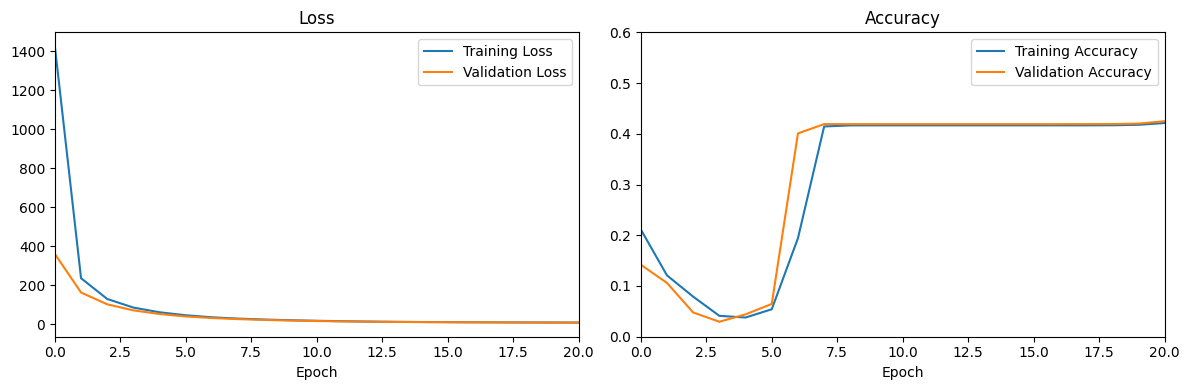

In [136]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist10.history['loss'] + hist11.history['loss'], label='Training Loss')
plt.plot(hist10.history['val_loss'] + hist11.history['val_loss'], label='Validation Loss')
plt.xlim(0, 20)
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(hist10.history['acc'] + hist11.history['acc'], label='Training Accuracy')
plt.plot(hist10.history['val_acc'] +  hist11.history['val_acc'], label='Validation Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Transformer
정확도가 괜찮게 나왔지만 learning rate를 적절하게 지정해주지 않아서 인지 loss가 발산하여 발표에는 담지 않았습니다.

### Positional encoding

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    # d_model = model의 입력 차원
    self.pos_encoding = self.positional_encoding(position, d_model)

  # sin, cos 주기함수에 입력되기 직전의 수식
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  # 위에서 정의한 함수를 통해 angle을 정의한다.
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 다양한 위치 벡터값을 생성하기 위해 사인 함수와 코사인 함수를 번갈아가서 사용
    # 이전에 계산한 값을 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 이전에 계산한 값을 배열의 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  # 최종적인 input 형태
  # positional encoding과 input의 word embedding을 합쳐준다
  # shape이 같기에 가능한 것
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot-product Attention

In [25]:
def scaled_dot_product_attention(query, key, value, mask):
  # Q와 K.T의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  # Attention Score
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  # 매우 작은 음수 값을 넣는 이유는 계산이 되지 않을 때를 방지하기 위함이다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight(distribution) : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  # attention weight => 어느 문장과 더 연관이 있을까~
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output(Attention Value) : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  # attention 가중치를 구한다.
  return output, attention_weights

### Multi head Attention

In [26]:
# 병렬로 Attention 수행
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의 -> Q, K, V와 곱해질 가중치
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

### Padding Mask

In [27]:
# 패딩을 제거해주기 위해 값을 가리는 Masking 과정
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

### Encoder

In [28]:
# Encoder 한 Layer 정의하기
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션(self attention)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


# 인코더 레이어 쌓아서 인코더 만들기
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
  inputs = Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

In [29]:
# decoder 레이어 정의하기
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = Input(shape=(None, d_model), name="inputs")
  enc_outputs = Input(shape=(None, d_model), name="encoder_outputs")

  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션(디코더-인코더 어텐션, not self attention)
  attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)


# 디코더 레이어 쌓아서 디코더 만들기
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
  inputs = Input(shape=(None,), name='inputs')
  enc_outputs = Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크와 패딩 마스크 둘 다 사용.(masked attention의 정의)
  # 미래 시점의 정보 차단 + 패딩 처리
  look_ahead_mask = Input(shape=(1, None, None), name='look_ahead_mask')
  padding_mask = Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

### Transformer

In [30]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
  # input shape은 항상 유지된다.
  # 인코더의 입력
  inputs = Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크 -> padding을 처리하기 위한 mask
  enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크 -> 미래 시점 찾고 못하게 가리기
  look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크
  dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size,
                        num_layers=num_layers,
                        dff=dff,
                        d_model=d_model,
                        num_heads=num_heads,
                        dropout=dropout,
                        )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size,
                        num_layers=num_layers,
                        dff=dff,
                        d_model=d_model,
                        num_heads=num_heads,
                        dropout=dropout,
                        )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]) # 문장, 인코더의 결과, masking을 위한 mask

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [50]:
# 논문보다 조금 작게 transformer를 선언
model_transformer = transformer(
    vocab_size = 18000,
    num_layers = 6, # encoder, decoder의 층 개수
    dff = 512,   # 피드 포워드 네트워크의 노드 개수, 2048 -> 128
    d_model = 256,  # 입출력 차원, 512 -> 256
    num_heads = 8,  # head의 개수
    dropout = 0.3,)
optimizer = keras.optimizers.Adam(learning_rate=1e-7)
model_transformer.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

(1, 18000, 256)
(1, 18000, 256)


In [35]:
hist6 = model_transformer.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), batch_size=128, epochs=10)

Epoch 1/10
 75/141 [==============>...............] - ETA: 26s - loss: nan - acc: 0.7812

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hist6.history['acc'], label='Training Accuracy')
plt.plot(hist6.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [51]:
# 논문보다 조금 작게 transformer를 선언
model_transformer2 = transformer(
    vocab_size = 18000,
    num_layers = 6, # encoder, decoder의 층 개수
    dff = 512,   # 피드 포워드 네트워크의 노드 개수, 2048 -> 128
    d_model = 256,  # 입출력 차원, 512 -> 256
    num_heads = 8,  # head의 개수
    dropout = 0.3,)

model_transformer2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

# 영어 - 프랑스 데이터로도 확인
hist7 = model_transformer2.fit(x=[encoder_input_train2, decoder_input_train2], y=decoder_target_train2, \
          validation_data=([encoder_input_test2, decoder_input_test2], decoder_target_test2), batch_size=128, epochs=10)

(1, 18000, 256)
(1, 18000, 256)
Epoch 1/10
141/141 [==============================] - 115s 207ms/step - loss: 14.1500 - acc: 2.9630e-05 - val_loss: 12.3071 - val_acc: 0.0000e+00
Epoch 2/10
141/141 [==============================] - 22s 153ms/step - loss: 13.7148 - acc: 3.7037e-05 - val_loss: 12.1847 - val_acc: 0.0000e+00
Epoch 3/10
141/141 [==============================] - 20s 145ms/step - loss: 13.3758 - acc: 1.8519e-05 - val_loss: 12.0756 - val_acc: 0.0000e+00
Epoch 4/10
141/141 [==============================] - 21s 146ms/step - loss: 13.1117 - acc: 3.3333e-05 - val_loss: 11.9999 - val_acc: 0.0000e+00
Epoch 5/10
141/141 [==============================] - 19s 138ms/step - loss: 12.9280 - acc: 1.4815e-05 - val_loss: 11.9164 - val_acc: 0.0000e+00
Epoch 6/10
141/141 [==============================] - 20s 144ms/step - loss: 12.7164 - acc: 3.3333e-05 - val_loss: 11.8489 - val_acc: 0.0000e+00
Epoch 7/10
141/141 [==============================] - 21s 146ms/step - loss: 12.5647 - acc: 8.518

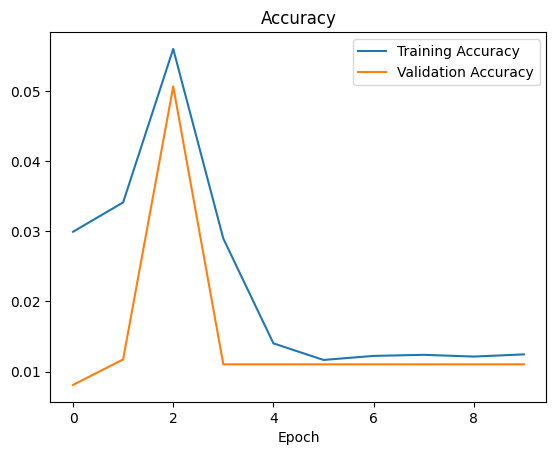

In [66]:
# 손실, 훈련 정확도와 검증 정확도 그래프
plt.plot(hist7.history['acc'], label='Training Accuracy')
plt.plot(hist7.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Model Summary

In [91]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             1273472   ['input_2[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 64)             1397312   ['input_3[0][0]']             
                                                                                              

In [92]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             1273472   ['input_2[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 64)             1397312   ['input_3[0][0]']             
                                                                                            

In [100]:
model3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, None, 64)             1273472   ['input_17[0][0]']            
                                                                                                  
 embedding_22 (Embedding)    (None, None, 64)             1397312   ['input_18[0][0]']            
                                                                                           